### Appendix
#### Homework 4

In [379]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report
from ISLP import load_data
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

np.random.seed(2)
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor

### Import Datasets

In [380]:
# Load the New dataset
new_safe_urls = pd.read_csv("C:\\Users\\david\\Downloads\\safeURLs.csv")

In [381]:
# New phishing dataset requires extra processing
import csv

def process_urls(input_csv):
    # Read the input CSV file
    with open(input_csv, mode='r', newline='', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header row
        urls = [row[0] for row in reader]

    # Split URLs by pipe and remove duplicates
    unique_urls = set()
    for url in urls:
        parts = url.split('|')
        for part in parts:
            cleaned_url = part.strip()
            if cleaned_url:
                unique_urls.add(cleaned_url)

    return list(unique_urls)

new_phish_urls = process_urls("C:\\Users\\david\\Downloads\\phishingURLs.csv")

In [382]:
import re
from urllib.parse import urlparse

def analyze_url(url, label):
    # Parse the URL
    parsed_url = urlparse(url)
    
    # Calculate length
    url_length = len(url)
    
    # Count letters, digits, and special characters
    num_letters = sum(c.isalpha() for c in url)
    num_digits = sum(c.isdigit() for c in url)
    num_equals = url.count('=')
    num_question_marks = url.count('?')
    num_ampersands = url.count('&')
    
    # Count periods, ignoring the first two
    num_periods = max(0, url.count('.') - 2)
    
    # Count special characters excluding slashes and periods
    num_special_chars = sum(not c.isalnum() and c not in ('/', '.') for c in url) - (num_equals + num_question_marks + num_ampersands) + num_periods
    
    # Extract domain and TLD
    domain = parsed_url.netloc
    tld = domain.split('.')[-1] if '.' in domain else ''
    domain_length = len(domain)
    
    # Check if URL uses HTTPS
    has_https = parsed_url.scheme == 'https'
    
    # Populate dictionary
    url_analysis = {
        'URL': url,
        'URLLength': url_length,
        'NoOfLettersInURL': num_letters,
        'NoOfDegitsInURL': num_digits,
        'Domain': domain,
        'TLD': tld,
        'DomainLength': domain_length,
        'NoOfEqualsInURL': num_equals,
        'NoOfQMarkInURL': num_question_marks,
        'NoOfAmpersandInURL': num_ampersands,
        'NoOfOtherSpecialCharsInURL': num_special_chars,
        'IsHTTPs': has_https,
        'label': label
    }
    
    return url_analysis

results = []

# process safe urls
for index, row in new_safe_urls.iterrows():
    url_analysis = analyze_url(row['URL'], 1)
    results.append(url_analysis)

print(len(results))    

# process phishing urls
for url in new_phish_urls:
    url_analysis = analyze_url(url, 0)
    results.append(url_analysis)
    
print(len(results))

url_df = pd.DataFrame(results)

3218
5204


### 1.1 Check for Missing Values

In [383]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   URL                         5204 non-null   object
 1   URLLength                   5204 non-null   int64 
 2   NoOfLettersInURL            5204 non-null   int64 
 3   NoOfDegitsInURL             5204 non-null   int64 
 4   Domain                      5204 non-null   object
 5   TLD                         5204 non-null   object
 6   DomainLength                5204 non-null   int64 
 7   NoOfEqualsInURL             5204 non-null   int64 
 8   NoOfQMarkInURL              5204 non-null   int64 
 9   NoOfAmpersandInURL          5204 non-null   int64 
 10  NoOfOtherSpecialCharsInURL  5204 non-null   int64 
 11  IsHTTPs                     5204 non-null   bool  
 12  label                       5204 non-null   int64 
dtypes: bool(1), int64(9), object(3)
memory usage: 49

There appears to be no missing values in the dataset.  This because all values were calculated by a script and give 0 when a character isn't found.

### 1.2 Check the Mean and Variance for Scaling

In [384]:
# Set index equal to the domain field
url_df.set_index('URL', inplace=True)

# Drop text fields and boolean fields
url_data = url_df.drop(['Domain', 'TLD', 'IsHTTPs'],axis = 1)

In [385]:
url_data.head()

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,label
URL,,,,,,,,,
https://docs.google.com/forms/d/1hM9Hkb1jP3rqqJ8o2-HToISKRqGbqlGNcFfBK0S3RYo/prefill,84,66,8,15,0,0,0,2,1
https://seattleu.zoom.us/j/95478319044,38,20,11,16,0,0,0,1,1
https://seattleu.zoom.us/my/earthmonth,38,31,0,16,0,0,0,1,1
https://www.seattleu.edu/cejs/campus-sustainability/what-su-is-doing/climate-action-plan/,89,73,0,16,0,0,0,7,1
https://www.seattleu.edu/staff-council/meetings/,48,39,0,16,0,0,0,2,1


In [386]:
# Check the Mean
url_data.mean()

URLLength                     159.626826
NoOfLettersInURL              113.398155
NoOfDegitsInURL                29.563605
DomainLength                   21.039201
NoOfEqualsInURL                 1.696387
NoOfQMarkInURL                  0.492890
NoOfAmpersandInURL              1.165450
NoOfOtherSpecialCharsInURL      6.665642
label                           0.618370
dtype: float64

In [387]:
# Check the Variance
url_data.var()

URLLength                     35095.559734
NoOfLettersInURL              22039.684225
NoOfDegitsInURL                1559.368431
DomainLength                     55.057467
NoOfEqualsInURL                   6.635459
NoOfQMarkInURL                    0.287284
NoOfAmpersandInURL                4.767739
NoOfOtherSpecialCharsInURL       63.466119
label                             0.236034
dtype: float64

The columns for letters in the URL and URL length are quite large compared to the other values, so it is probably best to scale the dataset.

### 1.3 Scaling the Data

In [388]:
# Drop true / false values
X = url_data.drop('label',axis = 1)

# Scale the dataset
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

In [389]:
X_scaled.head()

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://docs.google.com/forms/d/1hM9Hkb1jP3rqqJ8o2-HToISKRqGbqlGNcFfBK0S3RYo/prefill,-0.403730,-0.319301,-0.546121,-0.813979,-0.658615,-0.919679,-0.533801,-0.585709
https://seattleu.zoom.us/j/95478319044,-0.649299,-0.629184,-0.470143,-0.679196,-0.658615,-0.919679,-0.533801,-0.711246
https://seattleu.zoom.us/my/earthmonth,-0.649299,-0.555081,-0.748729,-0.679196,-0.658615,-0.919679,-0.533801,-0.711246
https://www.seattleu.edu/cejs/campus-sustainability/what-su-is-doing/climate-action-plan/,-0.377038,-0.272145,-0.748729,-0.679196,-0.658615,-0.919679,-0.533801,0.041974
https://www.seattleu.edu/staff-council/meetings/,-0.595915,-0.501189,-0.748729,-0.679196,-0.658615,-0.919679,-0.533801,-0.585709


In [390]:
# Check the Mean
X_scaled.mean()

URLLength                    -5.021604e-16
NoOfLettersInURL              3.430512e-16
NoOfDegitsInURL               4.763252e-15
DomainLength                 -1.569459e-15
NoOfEqualsInURL               1.436301e-14
NoOfQMarkInURL               -2.788221e-14
NoOfAmpersandInURL           -2.148875e-14
NoOfOtherSpecialCharsInURL    4.672153e-15
dtype: float64

In [391]:
# Check the Mean
X_scaled.var()

URLLength                     1.000192
NoOfLettersInURL              1.000192
NoOfDegitsInURL               1.000192
DomainLength                  1.000192
NoOfEqualsInURL               1.000192
NoOfQMarkInURL                1.000192
NoOfAmpersandInURL            1.000192
NoOfOtherSpecialCharsInURL    1.000192
dtype: float64

### 2.0 PCA

In [392]:
# Perform PCA
pca = PCA()
pca_out = pca.fit_transform(X_scaled)

### 2.1 PCA Principal Components

In [393]:
pd.DataFrame({'Center': scaler.mean_
                   , 'Scale': scaler.scale_}
                  , index=X_scaled.columns)

,Center,Scale
URLLength,159.626826,187.320089
NoOfLettersInURL,113.398155,148.443420
NoOfDegitsInURL,29.563605,39.485045
DomainLength,21.039201,7.419359
NoOfEqualsInURL,1.696387,2.575691
NoOfQMarkInURL,0.492890,0.535937
NoOfAmpersandInURL,1.165450,2.183306
NoOfOtherSpecialCharsInURL,6.665642,7.965797


In [394]:
print("Number of Principal Components:", pca.n_components_)

Number of Principal Components: 8


### 2.1 Plot the Principal Component Explained Variance

Text(0.5, 0.98, 'Principal Components Variance Explained')

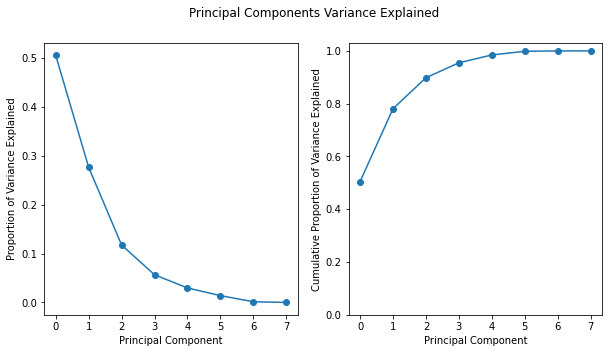

In [395]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot of proportion of variance explained
ax[0].plot(pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')

# Plot of cumulative proportion of variance explained
ax[1].plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cumulative Proportion of Variance Explained')
ax[1].set_ylim(0, 1.03)
fig.suptitle("Principal Components Variance Explained")

### 2.2 PCA Examine the Loading Vector Values

In [396]:
pc2_df = pd.DataFrame(pca.components_[:2].T,
            index=X_scaled.columns,
            columns=['PC1', 'PC2'])

# Top 5 PC1 variables
top_5_pc1 = pc2_df.loc[pc2_df['PC1'].abs().sort_values(ascending=False).index].head(5)
# Top 5 PC2 variables 
top_5_pc2 = pc2_df.loc[pc2_df['PC2'].abs().sort_values(ascending=False).index].head(5)

print(top_5_pc1['PC1'])
print(top_5_pc2['PC2'])

NoOfDegitsInURL               0.461515
URLLength                     0.434051
NoOfLettersInURL              0.394067
NoOfOtherSpecialCharsInURL    0.386374
NoOfEqualsInURL               0.301401
Name: PC1, dtype: float64
NoOfEqualsInURL      -0.515345
NoOfAmpersandInURL   -0.513835
NoOfLettersInURL      0.383566
NoOfQMarkInURL       -0.381205
URLLength             0.314049
Name: PC2, dtype: float64


Add description

### 2.3 1st and 2nd Principal Component Plot

Text(0.5, 1.0, 'First and Second Principal Component')

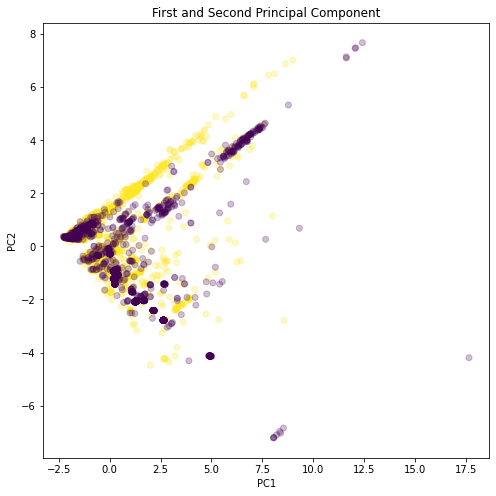

In [397]:
fig , ax = plt.subplots(1, 1, figsize=(8,8))

ax.scatter(pca_out[:,0], pca_out[:,1], alpha=0.25, c=url_data['label'])

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("First and Second Principal Component")

### 3.0 SVD

In [398]:
# Perform SVD
U, s, V = np.linalg.svd(X_scaled, full_matrices=False)

In [399]:
s.shape

(8,)

### 3.0.1 SVD Interpretation on U and V*

1. Since we are performing SVD on the scaled data of the original dataset, it is equivalent to performing PCA on the original dataset
2. The right singular vectors are the principal component axis.
3. The left singular vectors are the principal component scores divided by the singular values.

### 3.1 SVD Principal Components

Text(0.5, 0, 'Principal Component')

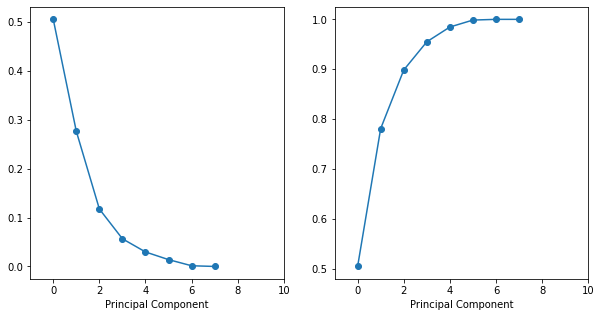

In [400]:
# Find the explained variance
explained_variance_ratio = (s ** 2) / np.sum(s ** 2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot of singular values
ax[0].plot(explained_variance_ratio, marker='o')
ax[0].set_xlim(-1, 10)
ax[0].set_xlabel('Principal Component')
ax[1].plot(np.cumsum(explained_variance_ratio), marker='o')
ax[1].set_xlim(-1, 10)
ax[1].set_xlabel('Principal Component')

We need at 4 principal components to explain over 90% of the variance on our dataset.

In [401]:
U.shape

(5204, 8)

### 4.0 Kmeans

### 4.1 Kmeans 2 Clusters

#### 4.1.1 Perform Kmeans

In [402]:
kmeans = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(X_scaled)

Text(0.5, 0.98, 'K-means - 2 Clusters')

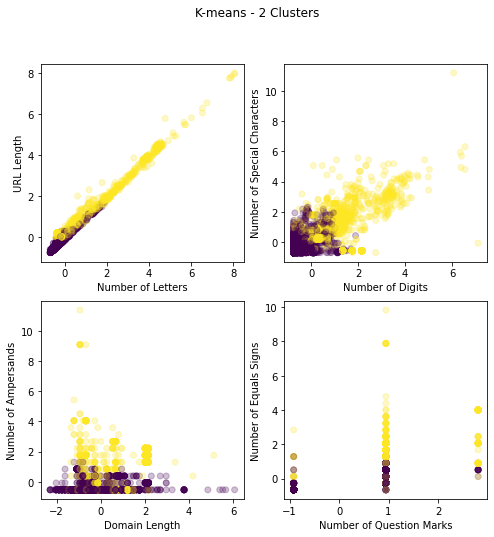

In [403]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].scatter(X_scaled['NoOfLettersInURL'], X_scaled['URLLength'], 
              c=kmeans.labels_, alpha=0.25)
ax[0,0].set_xlabel('Number of Letters')
ax[0,0].set_ylabel('URL Length')

ax[0,1].scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfOtherSpecialCharsInURL'], 
              c=kmeans.labels_, alpha=0.25)
ax[0,1].set_xlabel('Number of Digits')
ax[0,1].set_ylabel('Number of Special Characters')

ax[1,0].scatter(X_scaled['DomainLength'], X_scaled['NoOfAmpersandInURL'], 
              c=kmeans.labels_, alpha=0.25)
ax[1,0].set_xlabel('Domain Length')
ax[1,0].set_ylabel('Number of Ampersands')

ax[1,1].scatter(X_scaled['NoOfQMarkInURL'], X_scaled['NoOfEqualsInURL'], 
              c=kmeans.labels_, alpha=0.25)
ax[1,1].set_xlabel('Number of Question Marks')
ax[1,1].set_ylabel('Number of Equals Signs')

fig.suptitle("K-means - 2 Clusters")

#### 4.1.2 Examine the 2 cluster items

In [404]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(kmeans.labels_ == 0)[0]
one_indexes = np.where(kmeans.labels_ == 1)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)

[2381 3637 2288 2424 3413]
[4797 5162 3841 2362 2675]


In [405]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://calendly.com/aerstad/30min,34,26,2,12,0,0,0,1
https://doctorsofnursingpractice.ebemails.com/emailviewinbrowser?nid=6378616556879872&eid=6212950413279232,106,64,32,37,2,1,1,1
https://www.seattleu.edu/commencement/graduate-ceremony/,56,47,0,16,0,0,0,2
https://www.fedex.com/fedextrack/?trknbr=735987822831,53,32,12,13,1,1,0,1
https://groups.google.com/a/say.fitfusio.store/group/aa3/subscribe,66,53,1,17,0,0,0,3


In [406]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://tracker.club-os.com/campaign/click?msgId=4bf45c6f44a1c3542d0cd3040cadfc7356513144&test=false&target=https://www.anytimefitness.com/try-us-free/?club=3783,161,106,30,19,4,2,2,7
https://doctorsofnursingpractice1.ebtrk6.com/openurl?lid=5572115841679360&nid=6378616556879872&c=6474247711490048&a=5471085795737600&ae=5115680206880768&e_id=6490352200712192,174,57,98,36,6,1,5,2
https://doctorsofnursingpractice1.ebtrk6.com/openurl?lid=6318641943937024&nid=6378616556879872&rlid=6719527630405632&c=6489693017866240&a=5471085795737600&ae=5115680206880768&e_id=6277031644102656,196,61,114,36,7,1,6,2
https://redhawks-my.sharepoint.com/:w:/g/personal/asalehi_seattleu_edu/EedK_a1gY2xMlKUyyzrGYP0B91Bp1mIDaTmmiujSOa_vaQ?CT=1717302691484&OR=OWA-NT-Mail&CID=17280391-1c81-a425-8152-aa9b3214e7f7,190,117,44,26,3,1,2,14
https://track.canva.com/CL0/https:%2F%2Fwww.canva.com%2Fdesign%2FDAGGpnnGDQ4%2Fshare%3Finvite=JTjLA7A6w7X7gOdH0V6--g%26utm_campaign=designshare%26utm_medium=email%26utm_source=shareButton/2/0100018fc685cd1f-b1a35d93-eb69-41d6-b49e-3c9745d14e5e-000000/5-s1_qpHdLAsFN5gzqo4YaAqCngUKJ2p94iF-SuAj6w=355,298,188,69,15,5,0,0,27


ADD Description

#### 4.1.3 Compare Kmean Results to the Actual Grouping

In [407]:
def getAccuracy(cfMatrix):
    accuracy = (cfMatrix[0][0]+cfMatrix[1][1])/(cfMatrix[0][0]+cfMatrix[0][1]+cfMatrix[1][0]+cfMatrix[1][1])
    return accuracy

In [408]:
# flip the label from 0 to 1, to get the correct sign
url_data['label'] = 1-url_data['label']

# create confusion matrix
confusion_matrix = pd.crosstab(index=kmeans.labels_, columns=url_data['label'], rownames=[''])
print(confusion_matrix)
acc = getAccuracy(confusion_matrix)
print("Kmeans 2 cluster Accuracy: {:.2f}%".format(acc*100))

label     0     1
                 
0      2786  1088
1       432   898
Kmeans 2 cluster Accuracy: 70.79%


#### 4.1.4 Kmeans on 18 Principal Components

In [409]:
# Number of principal components
r = 4

singular_vector_space = U[:,0:r] * s[0:r]

kmeans2 = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(singular_vector_space)

Text(0.5, 0.98, 'K-means - 2 Clusters')

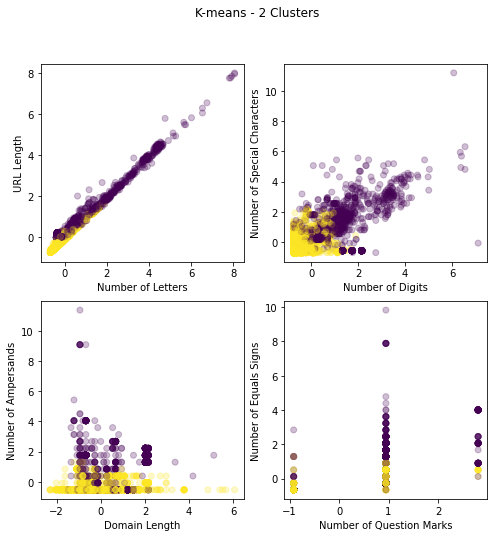

In [410]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].scatter(X_scaled['NoOfLettersInURL'], X_scaled['URLLength'], 
              c=kmeans2.labels_, alpha=0.25)
ax[0,0].set_xlabel('Number of Letters')
ax[0,0].set_ylabel('URL Length')

ax[0,1].scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfOtherSpecialCharsInURL'], 
              c=kmeans2.labels_, alpha=0.25)
ax[0,1].set_xlabel('Number of Digits')
ax[0,1].set_ylabel('Number of Special Characters')

ax[1,0].scatter(X_scaled['DomainLength'], X_scaled['NoOfAmpersandInURL'], 
              c=kmeans2.labels_, alpha=0.25)
ax[1,0].set_xlabel('Domain Length')
ax[1,0].set_ylabel('Number of Ampersands')

ax[1,1].scatter(X_scaled['NoOfQMarkInURL'], X_scaled['NoOfEqualsInURL'], 
              c=kmeans2.labels_, alpha=0.25)
ax[1,1].set_xlabel('Number of Question Marks')
ax[1,1].set_ylabel('Number of Equals Signs')

fig.suptitle("K-means - 2 Clusters")

In [411]:
# flip the label from 0 to 1, to get the correct sign
url_data['label'] = 1-url_data['label']

# create confusion matrix
confusion_matrix = pd.crosstab(index=kmeans2.labels_, columns=url_data['label'], rownames=[''])
print(confusion_matrix)
acc = getAccuracy(confusion_matrix)
print("Kmeans 2 cluster Accuracy: {:.2f}%".format(acc*100))

label     0     1
                 
0       902   477
1      1084  2741
Kmeans 2 cluster Accuracy: 70.00%


### 4.2 Kmeans 3 clusters

#### 4.2.1 Calculate Kmeans for 3 clusters

In [412]:
kmeans3 = KMeans(n_clusters=3,
                random_state=2,
                n_init=20).fit(X_scaled)

#### 4.2.2 Plot the 3 clusters on some variables

Text(0.5, 0.98, 'K-means - 3 Clusters')

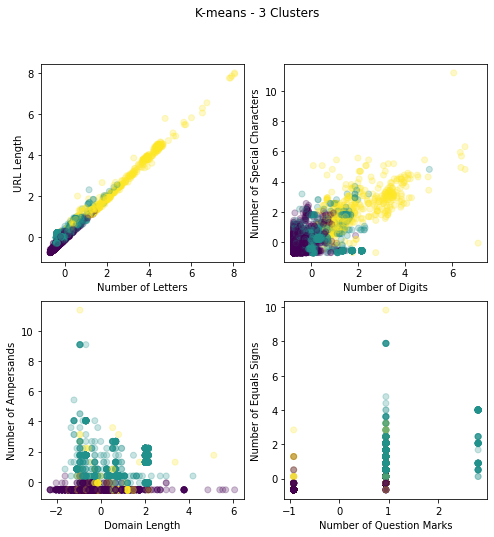

In [413]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].scatter(X_scaled['NoOfLettersInURL'], X_scaled['URLLength'], 
              c=kmeans3.labels_, alpha=0.25)
ax[0,0].set_xlabel('Number of Letters')
ax[0,0].set_ylabel('URL Length')

ax[0,1].scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfOtherSpecialCharsInURL'], 
              c=kmeans3.labels_, alpha=0.25)
ax[0,1].set_xlabel('Number of Digits')
ax[0,1].set_ylabel('Number of Special Characters')

ax[1,0].scatter(X_scaled['DomainLength'], X_scaled['NoOfAmpersandInURL'], 
              c=kmeans3.labels_, alpha=0.25)
ax[1,0].set_xlabel('Domain Length')
ax[1,0].set_ylabel('Number of Ampersands')

ax[1,1].scatter(X_scaled['NoOfQMarkInURL'], X_scaled['NoOfEqualsInURL'], 
              c=kmeans3.labels_, alpha=0.25)
ax[1,1].set_xlabel('Number of Question Marks')
ax[1,1].set_ylabel('Number of Equals Signs')

fig.suptitle("K-means - 3 Clusters")

#### 4.2.3 Examine differences between the 3 groups

In [414]:
# Get examples of URLs from the three different clusters
zero_indexes = np.where(kmeans3.labels_ == 0)[0]
one_indexes = np.where(kmeans3.labels_ == 1)[0]
two_indexes = np.where(kmeans3.labels_ == 2)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
print(group2_random_indexes)

[1449  571 1856 2034  643]
[3817 5013 4163 5007 4687]
[1566 3760 4556 3268 2527]


In [415]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://seattleu.csod.com/ats/careersite/JobDetails.aspx?id=1524&site=2,71,53,5,17,2,1,1,2
https://forms.gle/b9QqMn8L4vyFo1us7,35,25,5,9,0,0,0,1
https://www.marinalexisart.com/,31,25,0,22,0,0,0,1
https://forms.seattleu.edu/#/form/87,36,25,2,18,0,0,0,2
https://www.seattleu.edu/media/human-resources/files/benefits/2023-Vendor-Directory.pdf,87,69,4,16,0,0,0,5


In [416]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://doctorsofnursingpractice1.ebtrk6.com/openurl?lid=5572115841679360&nid=6378616556879872&c=5242147121397760&a=5471085795737600&ae=5115680206880768&e_id=6332366996111360,174,57,98,36,6,1,5,2
http://report.mnb.email/t.js?s=66594ccfb78810097f22637d&u=50535997&v=3&key=1163&skey=feb4d0b3b2&url=https%3A%2F%2Fblacklawrencepress.submittable.com%2Fsubmit%3Ahttp://report.mnb.email/t.js?s=66594ccfb78810097f22637d&u=50535999&v=3&key=59b7&skey=feb4d0b3b2&url=https%3A%2F%2Fblacklawrencepress.com%2Fbooks%2Fearthwhere%2FPre-Sale,328,195,80,16,12,2,10,21
https://doctorsofnursingpractice31.ebtrk6.com/unsubscribe?nid=6378616556879872&c=6568837386862592,97,52,35,37,2,1,1,1
https://ecp.yusercontent.com/mail?url=https%3A%2F%2Fwww.docusign.net%2Fmember%2FImages%2Femail%2FdocComplete-white.png&t=1690852390&ymreqid=ed60c7b9-4e7c-6908-1c7c-00004b019100&sig=CSIwOl0h6Soye3fTeKvayw--~D,207,132,43,20,4,1,3,19
https://www.mnb.email/tools/subscription.php?username=indiebible&send_id=66594e3fb788100987387acc&l=s&newsletter_id=1417042783,126,80,28,13,4,1,3,4


In [417]:
# Third Group
X.iloc[group2_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://email.axioshq.seattleu.edu/c/eJyNkD1uwzAMhU8TLYUCivr1oCFLrlFQolSrcOLUVpC2p686dMhWgACJB_LDe1y3N7q2b-ptvb42jsjaIGknS2aUhlnLkKyVNgVX2LuCYESJyjkLk1YwCY5E7AOLFhEQFYBDZUGbI4DxGpB5qjYbzQcD9NnWff447oV6X8r9WPgu5uiUJmUcZNaUArCpSTtFbCevbNVOLHHu_bYf9OmA51GPx-OJMaSWex6tUr4v_WtMWxkbW55lLcuyPva5DQCexV62VvbfsD4Hxc4EmckmaRI7STBVWb1TYEzS3k5iizdaLmV7H_afbBduf1_zmTBBNRJV5gFKWk5slawVMaDXHDCJHk-ZuFxafjnVSm3bh_Sfyx_2jn96,409,339,52,26,0,0,0,12
https://ci6.googleusercontent.com/proxy/kHoSluCYagpqFYZU80vGtu2UplxNrH22kMg00F29YOITl61n8WoQECnENaAzceVrjqsJpUZz5kg36DJYOH9ogP2v67BVBYNDnTCtqd1x5i6BltKvcVppXFKoya1uLzaqWo421HTsvKX4FAqMdZ00soY9y3vlIsurQIt_VprlRa1846DtLArDSqBJbG885qHQlV9ezDdCXnM4xHLDbOjs5SOkWPf-xzJSZi1FthDIjRTC1yJknRAlYyJTZUc3GVpEcf85HRIJBgJ8RRD0L0E9GD2z1ZEqqLByDPXvB0WUQRX1hvH9DUtkdAyMcbvnp4D_9ryaNHgPN1b-J5JdYtW7CZ4=s0-d-e1-ft#https://ecp.yusercontent.com/mail?url=http%3A%2F%2Fassets.squarespace.com%2Funiversal%2Fimages-v6%2Fmail-assets%2Flogo-2x-a85daf0c47ce077e64cad6.png&t=1642132885&ymreqid=236f17c9-5cf9-81f6-1c14-9d000b013900&sig=4afMMjai0ReroIYztKT_hg--~D,632,460,120,25,5,1,3,34
https://ablink.transactions.earnin.com/uni/ls/click?upn=u001.SUmKYsSeX26nJj3C26bNx1l7WIYJnILRMxMGLqfcEC-2FwrGu2VxjqoyIzoiiQoNxomUyH_Nmuxu6LuKttWZ2PGLNUJbTC3k2oFmPGNjtVd1IM05R4O88E3OTzkFZiOGK35lgj2EsKUlODz894JjsYGOY1qVd-2BuwhR3jri4JjWqr0e1le0UIyKO8YV3h4FLukgg1M18HSOs1sB16Xhoanhnak0iYKVTT2dJspRj-2FJSnW4l3TLcdmORukmbzNjgD2k0MsGdlJOadrhO46wCEx0ygHV21xNiI1knwBnFa4ZFdLbVCQe2EkJ3dB-2F8mcq-2B0vDRB-2BTEajav4D2KpXazf42A5fbLFHpS1jJbr6Bn53bUTwUI1L8eBwkr9BiS9wXXqukTiFeFJuRE-2BQh0mjWhYalDNyfUkcdz37wBWnU6bNuZ9OUHkE-2FJAB7-2BrulEPeDrqkKg-2FtQaR2UXTSc1v2j6y9y9Bmf5Z53PM7AmpE-2BdJnvE8AQpOlXNXVWWq6ARMHQS75cV5ijLaqaNTvmzGXwOOSboi4gaNi7ghxAYssSUsaoCQZB1Ra9Jp11NpfI6itAzJd609HFqIf5AiT196XGocsEVUYv2sko3pvJQ2ZklHWPVoNPCLs2qzY7f-2BDo6PpRQt9q2FrojQq0P-2F3otTC-2BQ-2B6-2BleO9Zhi-2FsMRfQZGwTqH8zyGHfJsZ3LWqZpFwtqyEyYteoOYJNuCYlGkLkFjB8kOKh7YEXICG0-2F6-2Bvc2xeM0sUjJsFvXioeOIN7lsG2DZhaGSc-2FM1ke03HvvEvsQFItzK7b4ikNT5tlQWxw1W6BUD-2FBXDYc21GstTotfodVwzLYgD-2FEdNfL,942,745,162,30,1,1,0,26
https://ablink.transactions.earnin.com/ls/click?upn=u001.SUmKYsSeX26nJj3C26bNxzRqc9iG5QMlaFYCgi-2BGfyB12IXl-2Fay-2BYiEXMqnedYwev0aG_VFvK-2FtaFrmzhX8zBwEnmTMfm2W44dnOA1TlSCTSBQvtFH0E8r3tSRtNwiw-2FJMOVu6cMKD4Uk3rsOnvUz-2Fe9eA0Yzo83LOmENM6QolVbxn-2F-2Fj-2BidLIPj8JKAB9scnsf158Cis-2BN-2Bnj-2Fan61IF6vwh8rMF5-2Fw2inPIKAMbWibmVT5n0pVWbac6bneSHCOGd9pKXSM7M6QHSpqpPZXy98-2B3zCMkYioJ73SuK1kg-2BzeR9K2rVtBDKIQWZHIJJBPqUvDwsFnEzhXh5u6DZUeJAiPobQY6af7IMzqnKsQWg-2B6h0i2jzvogaFKVUjzJW33YsCHrf7EUTFBnQ0dTC47LVrYwe0FdyuKztvxtIoCz2HgSkWlwoMTIwse7GgU3oy8GhOvNmuy6eyFPFsUg7bu0zd9M2T8lZ1EGEUM7IkPTJhC0D2Ty3DrpvvYvXSPeX1sgacvOsi8iJEr8q5GNeQDJMKZ8A7Em-2BLdIdcLtGG-2Ba79OYsiE7Vds5q0WgPPnCh-2Bhp1vO0CS6qeFlHJctN-2F21aIDPBcZTQbo6-2BEiFApJHdpqJkTtfcXx35IEXRcliXA-2FyI6MRA-2BAkWP4UcGkJ8sN27tQ-2F2GgR-2FdrJFQDYgYAaoiqPeuzMEZHMzcEIjbRGWmgN-2F8Oe3-2BstNvRxJq8KrGQoSuTaoBMiRSacL-2FLaF-2FaBDKzguXF0-3D},871,686,142,30,1,1,0,35
https://www.biovittawellness.com/_t/c/A1030004-17D40DC72D75427D-FE7AFABB?l=AAD%2BQ%2BlduReBV6hHDB6vmrp65FAHxbj3aX%2FOka2didgvsVTCui1qxPDC4ibRkFftwX3xeADqZLqBiIDdcvOPLBodeKVO%2FuOZGDMhcgAJRbrJwhRYC4VWSmGWo%2BuJ1utZHZYdjCBE8eQ5OtijGSjkVyEVtiPhEa1Qh97w9xHstBB6TrahNQ22rOokD0QAQ8KzzBAWDT0rbHBAckV%2Fv7g5DKz%2BRs0YPFCTuK1Mb5kahVoADCgrB54OdFQ1%2F%2Bgz&c=AACN87rgQlYICCQAH6HkzZpELno1UkfPJoDjLmosWOW3enVVs4TAhfxh6dF%2BvC3FuZv5K8x9VcwTbrrU5yZoJlzWfHXd1UVWPbhLpLowQgJO68B9StVjgYvem10nqfnB%2BFrTFpRz0jjqRE3leXW5w9otdHdqo9Mu7Dx0vjQPEYmvSJPvcBZm7ZjQju82N9A1j%2BY3oajqW0HH%2FIOSrV6BsRjP%2BXwq8GA5zeu0LcAzz2pbDWi9vVy7bPUje%2BT2%2FHxjPEjeSj1fRc1kxQyi8VSC0VBH4JWN60PxiT36lYL25M6tSq2urskhD7em%2B3N7j1oB1V7MT8kJDB56gtp6qapzlS4g6fTA8fane0IdMOMtWQxBlhqJeu7Emg9fUpClykxJOF1UYd2wUwYVmNL5vNQlAFrs3nJmIBM0W%2BjAGCI4thxVH66fus7rewUXXs8lbL6fv2knQnPhxD3cAwVwj%2BK6D5YecrOJ3YY%2FwrcfspmoLp%2BEKek3,868,675,157,24,2,1,1,25


In [418]:
# Cluster sizes
print(len(zero_indexes))
print(len(one_indexes))
print(len(two_indexes))

3145
1487
572


### 4.3 Kmeans 5 Cluster

#### 4.3.1 Perform Kmeans with 5 clusters

In [419]:
kmeans5 = KMeans(n_clusters=5,
                random_state=2,
                n_init=20).fit(X_scaled)

#### 4.3.2 Graph the 5 clusters on variables

Text(0.5, 0.98, 'K-means - 5 Clusters')

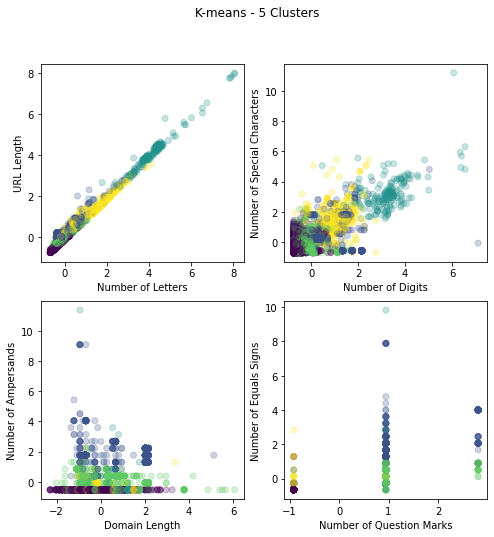

In [420]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].scatter(X_scaled['NoOfLettersInURL'], X_scaled['URLLength'], 
              c=kmeans5.labels_, alpha=0.25)
ax[0,0].set_xlabel('Number of Letters')
ax[0,0].set_ylabel('URL Length')

ax[0,1].scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfOtherSpecialCharsInURL'], 
              c=kmeans5.labels_, alpha=0.25)
ax[0,1].set_xlabel('Number of Digits')
ax[0,1].set_ylabel('Number of Special Characters')

ax[1,0].scatter(X_scaled['DomainLength'], X_scaled['NoOfAmpersandInURL'], 
              c=kmeans5.labels_, alpha=0.25)
ax[1,0].set_xlabel('Domain Length')
ax[1,0].set_ylabel('Number of Ampersands')

ax[1,1].scatter(X_scaled['NoOfQMarkInURL'], X_scaled['NoOfEqualsInURL'], 
              c=kmeans5.labels_, alpha=0.25)
ax[1,1].set_xlabel('Number of Question Marks')
ax[1,1].set_ylabel('Number of Equals Signs')

fig.suptitle("K-means - 5 Clusters")

In [421]:
# Get examples of URLs from the three different clusters
zero_indexes = np.where(kmeans5.labels_ == 0)[0]
one_indexes = np.where(kmeans5.labels_ == 1)[0]
two_indexes = np.where(kmeans5.labels_ == 2)[0]
three_indexes = np.where(kmeans5.labels_ == 3)[0]
four_indexes = np.where(kmeans5.labels_ == 4)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
print(group2_random_indexes)
group3_random_indexes = np.random.choice(three_indexes, size=5, replace=False)
print(group3_random_indexes)
group4_random_indexes = np.random.choice(four_indexes, size=5, replace=False)
print(group4_random_indexes)

[ 578 1709  201  867 1159]
[3524 3623 4941 4867 4611]
[2653 4989 4731 4526 1242]
[ 264 5054 1203 3111 3329]
[3196 2489  967 2146  285]


In [422]:
# Cluster sizes
print(len(zero_indexes))
print(len(one_indexes))
print(len(two_indexes))
print(len(three_indexes))
print(len(four_indexes))

2368
792
177
1401
466


In [423]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://northwestdharma.org/seattle-woman-and-seattle-university-professorheading-global-buddhist-womens-group-sakyadhita/#post-26366,133,110,5,19,0,0,0,13
https://www.seattleu.edu/faculty-development/events/#d.en.3897077,65,46,7,16,0,0,0,5
https://www.facebook.com/sucampusministry/,42,35,0,16,0,0,0,1
https://seattleu.zoom.us/meeting/register/tJAod-6trDwrE9BnfaTIhnRsvqi6WSmKYoIo,78,66,3,16,0,0,0,2
https://www.skillstat.com/tools/ecg-simulator/,46,37,0,17,0,0,0,2


In [424]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
http://report.mnb.email/t.js?s=66594ccfb78810097f226372&u=50535997&v=3&key=1163&skey=de0f77cfec&url=https%3A%2F%2Fblacklawrencepress.submittable.com%2Fsubmit%3Ahttp://report.mnb.email/t.js?s=66594ccfb78810097f226372&u=50535999&v=3&key=59b7&skey=de0f77cfec&url=https%3A%2F%2Fblacklawrencepress.com%2Fbooks%2Fearthwhere%2FPre-Sale,328,195,80,16,12,2,10,21
http://report.mnb.email/t.js?s=66594ccfb78810097f226380&u=50535995&v=3&key=d023&skey=38a93cf3e6&url=https%3A%2F%2Fblacklawrencepress.submittable.com%2Fsubmit,157,91,41,16,6,1,5,8
http://report.mnb.email/t.js?s=66594ccfb78810097f226375&u=50535987&v=3&key=d023&skey=5a9bc521ee&url=https%3A%2F%2Fblacklawrencepress.submittable.com%2Fsubmit,157,92,40,16,6,1,5,8
http://report.mnb.email/t.js?s=66594ccfb78810097f226389&u=50535993&v=3&key=59b7&skey=a48114f65e&url=https%3A%2F%2Fblacklawrencepress.com%2Fbooks%2Fearthwhere%2F,160,90,44,16,6,1,5,9
http://report.mnb.email/t.js?s=66594ccfb78810097f226381&u=50535997&v=3&key=1163&skey=3fe1c10cee&url=https%3A%2F%2Fblacklawrencepress.submittable.com%2Fsubmit%3Ahttp://report.mnb.email/t.js?s=66594ccfb78810097f226381&u=50535999&v=3&key=59b7&skey=3fe1c10cee&url=https%3A%2F%2Fblacklawrencepress.com%2Fbooks%2Fearthwhere%2FPre-Sale,328,193,82,16,12,2,10,21


In [425]:
# Third Group
X.iloc[group2_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://email.notifications.joinhandshake.com/c/eJyE0U1z4jgQxvFPI25QVrf14oMPCWCyKUiALCThQsmSDDZ-txwMn35rJ5U5TdWcf_--9GNCMAEXIxtSQXkATFIcnUMPA2Yl00pRKqUFYEIbSERshOYxsFEagge-x0DSgHkUJ9xnFAW1oCXzfMaI75WVS5NUK5dWZTfJqrQ8q9J0Z3WxE10Vozw8O1d3BB8IRASiPC0vf-gIRIpApPNUXwhGR0dwliA1VGJsMLC-JzD2JUWurLSBNMpPCPBjQXBm49jYhEHMlfWl5ioOpFSIlPlGcY_931mCs6YLknLw_Lp9G6_-Xahew9tTrEyjlzIazuie7y3So8Cvun08HBbz_WuW9VG_2p3X11N7R--0uMzkeOqfEi-oymy16-rxx-dtnC3ZfIfsVuybueTRV5bn6xbXNmfb132fHe-beVeBzq9i-dZ94uKava_Xh6rc9vT1eb1fjTe3ZfN0uLpioJ3g4-mheEl2-ikYZtOPE0z7Hb3z7bXYbm60l8P0uHlplllTJeulzPrsfdjSl9KtHlY2_bgPK29DgOFsVFinjHIqJOKRABS269TJ_mMIwK894O-fAwJTAuBsUefK_b4NBOc-0m-s2yqz2v2YRIHfoFVRq_RU_ohA4BwYEbNRGzauVSUnvtdZ5Vxu-4k1_egrhP8CAAD__-IZ0c4,719,567,108,37,0,0,0,38
https://trk.klclick.com/ls/click?upn=licKyYicjDdrrDZqZOyUMpsWGFq8CU-2FuSRDt5ZvagtS1BWM7hSc9O7r-2BNIC-2Bv2OcGeH5V-2BRDhGMJQbLBfILu8ZLs7bMVPoYs12eNBjWCHQB-2BP2SJ0JFr-2ByMma70fDIUCahuiVn5lZrIJmIXWYQw8EeQMfoAKe6ARu0VAy8qNifmKBbdU8U6iNZ6W5x1lQ-2Bw7NsMDsw9LggJ6ski-2FKkYZIIZJymLyhNgdgCJ2xuEx5ysHc1YcGmcFAlqKRJOduuRInzbBBnb8TcHHKZmRzvhf7mzO-2Bfxa2cH5fY6ih7xPMIENyLVwKF4wAuXmxj9-2BSi1HtJo7_x7nr0ntPKoWPPIWfPMLvZM1-2FNxwrHHIQPHyKplewZAKGHDoBFx1iK1cghi87JxxeLrDZl0YtwbM77FgLySblZ5scUDwvZQyPT-2FY8XYG4VEV9yV5XyYF3d-2FT6mwKWsKcExdZv-2BZFxyFVEHWZ0zA7R6ejTl8JD7gAj1Gyw-2BBNkfc0aJAdgBVamvbDNebvjIc0y5j-2BgIMrmw5ku-2FRupheasLD8C2Hm6tIWKv1QeBdS2gXrKjUutm-2BmOj-2F9KYs-2FBLOsVVBf70pWYHUKlpmBVLqrUN9HZJ1umkYmk7POfY-2B38fpTeLePIYsMmCHjz-2F7hO7ztVlJNLs3d9riRmP5E1MC4mRHNG9WkJAluvCQ3y-2ByTAEIpYoQShqD9HIx0c3gWtsIH1oayI1yGANZ-2BCqu0vEBv0WQ-3D-3D,822,662,124,15,1,1,0,28
https://ablink.transactions.earnin.com/uni/ls/click?upn=u001.SUmKYsSeX26nJj3C26bNx5qH4S2a1JEitFBko5K2mNOUU8eT5D0dzuFuEJ-2F06sjYiBvO_2leoliQ6CNyHLiS2I0NGY6MkcGEJJq7d8JYsA37YkkmPCdC3lLnYIPvP9bDFaIaIpmtteyKOqWdFYNoNeU4pZmp2tcW4OlL-2F6MO-2FeZambYWX-2FwiXZ64QVweFPhwEkvxPjmVgSByEgv5FUegYFDDN6FpLIjD00232Q-2F1YeGtWf2DChnb3bUzsUe4A7t14XgYDnnq8dMgKSUKU091sBF6soqWrc6q7tEc1Lr-2F124oxd1hHiJHj76djiAu0Ow08h5vpv-2FmBk-2BAWe4DnclgOvNqRZtRwNnrVMkPxUCd22LgxOHY3R1-2BaI5EDAUdc7-2FRTL0Klnli7Ga68ZxKW7T9drcPKvcLi2oiZYyb8s7GvRwLOrHp0Mvs24QWRDcEx2xcPl8iyJOomaPbm3A90c-2BwmlCcM6hIZ2yAVbRugMdGVKL7ab0q1XeAqv81vuJvmUoNCEXx-2F-2BSARH5Uy7ZcrV1GhKJQy17yr17MqCd4bpqJwOqahrYxlnKj5oPs2izWeJJVTgeMB4MayMFNZ8nbGyvWvli4b7J5XoY7ozRiHQ25yO2wuDKeckW0x8W-2FjabN-2BDJXbd2u06UISXczc2YmuW4LIuOCmxZRAMJiX-2FKcIXeMfn0BOVjRdOWypfm7-2BJgeECCPOlfhIRYXoI6ApfAGA99IApLwNjgvGIhUm466d6o-2FfVFZgZUOZ7IHr0eWvILlq3SN-2BNwpX,872,684,156,30,1,1,0,23
https://ablink.transactions.earnin.com/uni/ls/click?upn=u001.SUmKYsSeX26nJj3C26bNxzRqc9iG5QMlaFYCgi-2BGfyDA5x91KBGw0NvN8hqpJCqx40UpDRviZ-2BVy8n-2B-2F5nye6g-3D-3DDZyt_VFvK-2FtaFrmzhX8zBwEnmTMfm2W44dnOA1TlSCTSBQvtFH0E8r3tSRtNwiw-2FJMOVu6cMKD4Uk3rsOnvUz-2Fe9eA0Yzo83LOmENM6QolVbxn-2F-2Fj-2BidLIPj8JKAB9scnsf158Cis-2BN-2Bnj-2Fan61IF6vwh8rMF5-2Fw2inPIKAMbWibmVT5n0pVWbac6bneSHCOGd9pKXSM7M6QHSpqpPZXy98-2B3zCMkYioJ73SuK1kg-2BzeR9K2rVtBDKIQWZHIJJBPqUvDwsFnEzhXh5u6DZUeJAiPobQY6af7IMzqnKsQWg-2B6h0i2jzvogaFKVUjzJW33YsCHrf7EUTFBnQ0dTC47LVrYwe0FdyuKztvxtIoCz2HgSkWlwoMTIwse7GgU3oy8GhOvNmuy6eyFPFsUg7bu0zd9M2T8lZ1EGEUM7IkPTJhC0D2Ty3DrpvvYvXSPeX1sgacvOsi8iJEr8q5GNeQDJMKZ8A7Em-2BLdIdcLtGG-2Ba79OYsiE7Vds5q0WgPPnCh-2Bhp1vO0CS6qeFlHJctN-2F21aIDPBcZX3jc-2BX-2FJuRWduE62ZBrAzUmqflVmjipvrG4GLpfdwcT7pFbiOWuECGCJYBPtkp1167odoGgHP-2FDFYs5utHyjSGepdSAFBoxr1RslLRqP3-2B5P-2B59HZqTDimRjtU8uNo6-2FjuHiEH0P29VninCehrYBE-3D,898,699,156,30,1,1,0,34
https://email.axioshq.seattleu.edu/c/eJyNUstu2zAQ_BrrUtCg-NbBh8SuAxsx-sjDTS7FilxGjBXJkWQ7zteXklIgvRUguDvkcnY5mLp5giq8Qxfq6ndwM-a4YMAVQesYEc5xYnIpicyNQqcVMioSNwNw2rgkzBhlcaWGUiaFmnoujKXAI4LcGz8RFN5C3Rav0xah60o8TNEdkmIGGdXSZoaKnGOmhIUYNaSZVtSAY0k5K7pu3074xYQt46rghbJpCx7LUO3a6b6pO7T93NP60JV1vZva-qWv5ctDU074YnzPZM8ge4647Q95GWyBUHZFqNrgsBmfxbv-L0NCx5CqIRzB2lANCpEjNsEHO4J9HanOpKsJVo5AS2pPXqCxBUk_GioHHcRJqIgHek7TIXQFYt9R0M-aDFfGQR5VMClESTzV1mqkxm

In [426]:
# Fourth Group
X.iloc[group3_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://www.facebook.com/hashtag/netzero?__eep__=6&__cft__%5b0%5d=AZVaVQIwa1aa_8m6KSx0oAa-G6J7sF2NsARWv9D8eqia21aDG4J9QhsM9UqBUXz-flfXRtgGLeZGt8TTnVxljcDhYB_a1UkgxsbkmknTXKqvWWHjMVdHlHlnc3UlfaCQ_gYhpUluetUHHpdZotk0Kpbu&__tn__=*NK-R,231,175,22,16,3,1,2,22
https://www.mnb.email/tools/subscription.php?username=BlackLawrence&send_id=66594ccfb78810097f22636b&l=s&newsletter_id=1417041077,129,83,28,13,4,1,3,4
https://extras.apa.org/apastyle/basics-7e/?_ga=2.97921503.1782467597.1600279017-1296463417.1600279017#/,103,34,50,14,1,1,0,9
https://apple.news/PwvUSW7HkEw6q7QOViyR-9m?articleList=Am9-RyiVOQ7q6wEkH7WSUvw,78,61,8,10,1,1,0,3
https://booksite-app.appspot.com/link/6538/CNL19/20240531/AU1?url=https%3A%2F%2Ftwitter.com%2Fgptxlibrary,105,68,19,24,1,1,0,7


In [427]:
# Fifth Group
X.iloc[group4_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
URL,,,,,,,,
https://email.axioshq.seattleu.edu/c/eJyNkLFOAzEMhp-mt1SpEidx0uEGJMSKBA-AnNh3DbR3cJe2iKcnHRi6IXmwLPvT93teRprKD9UyT2-Fe2DrgCwqyQzKMVsVk_fKp4jCAQW067gn4hC5Kz1oAG2tNsEbF3ceozYwWCTEHEU2TtN3mdfD124VqvUo553wuTv00YhB2DOB1168OG8gBxoMIqO41B37Q62f68Y-bOCp1fV6vWO0EfGFpiyt61ZZiqy3BEjaAqBtysEoZzgp8uCUUHIMwQ4pDd3SX9T7Ked5OVH-aJZ3dsLl7x9BOOEAojyxVy7ZqPb7NKgczGADcgubu9q_SBmndjSN2-fzsn2tC1UZS94-lkXyDba2rf_AfgHHaHw5,401,314,69,26,0,0,0,12
https://u28117927.ct.sendgrid.net/ls/click?upn=u001.Lnsf-2FL0TVoEz2D9uw2FYr3DbY9TDC25-2FpFLyb1QcSTZCNatAzyfCor77fBfnHF-2Bb-2FXTSmqU-2B5wLQXhPclLJQ8Nu0SqjUyjMyejzC-2Fn2VfumZi-2B9iz0foNHrpA3gcVAzqOQJHexUNZG2rHSgSBYAJrQ-3D-3DjWQr_lTtQTk6B-2Fp2ACKVbPILivIepldrzG7FR63DYoRG-2BmAGIlRA6ZxyQIazjB4QycEoRjCgxBeyGa7LfIGlNK6wEUPfac9CwVIFov7n8thLOthueJu5aj2wYcS2OT1xQXI-2FXh693qF-2FeTJKisMwXX8p-2FRx9yIjOo028R6BcWqUHTmqgN27pLp9-2FWTIgt9HWDNmwVJWvsA5hHLbw4u-2B-2Bsh15bpw-3D-3D,463,350,82,25,1,1,0,23
https://email.axioshq.seattleu.edu/c/eJyMkL1u3DAQhJ-GbAIelstfFSzS6AWS1MGSu7Jk3Em2xPPZfnrDBlxc526KwWC-jwsRp8xaio0ZQgguRi289GVb_y9cCGtuHMHYBtX4ZMkMLUczWII02KkOEfVc0E1DjcnbNgVf85CgtUiNpgZpgpT1UhDQgQeHEFyAk40VHdWJwUXISMoDvS7bMT-fDqHez3I9CV_1ucy9Px3K_VY4Khxvt9tdQeHY5PFQOMqLrP0r0N7ny7b2WeGot_2B1uWdvomQnUdy0UhjNJ7ZmVxDMKHmKJyiIHi9lz6LXJSHuzOH7IscnyvJSrRog7FOBuOFmiGhbEKdHDUXnXDSvfz59-vvxvSm-49MfgQAAP__iDp3pg,403,331,53,26,0,0,0,13
https://email.axioshq.seattleu.edu/c/eJyNkLFOAzEQRL8mbpAj367X5xQuaPgBoEbr2z3O0pGD2CGEr8cUFOmQpngaaVczs51e-Vi-uZXt-FIkgaAHxmB1ErBeBG3MRJZyDCpjUHDeSGKWMYopCRyAIwfDAQaA_SQ0-05eEDFn2nnHX2Wry8e-Kre26nmvcjZL8nKQmQncrBNlpyMFzzNmyIIiEcyaltbe6w7vd_DQdblcbn50S0rlXNbSrrbq6bNMWrtrOhetv20mQmL0asGpWg-T2syM1oU4OxzGXhTMKbVF9a1HvYmoUv5GGTzxGDLY6IaD9R1tHiHY7GKYWckPTk1Lj893T5vwteN_Ln4AIPpyPA,375,310,48,26,0,0,0,11
https://email.axioshq.seattleu.edu/c/eJyNkL1OxDAQhJ_m0iBH9jr-K1LQ8AJAjdbeDbF0Fx-Jc8fx9PiQKOiQppnZ1UjflPUdl_yFNZflLdMIpAdAbQUnAjEQaeGjMcJEb5mcZZBDRyMiOU9dHkFCS8CDlmFQvfLOxUmxjMqzZzwMEj9z2eaPfmOs9ch7z7R38xhNIq1ZwQSUhmCdUjI5aaLFFAhCdxznWs_bQT8e4Knper32iVL_Xi7NpbKWBS953bfmQKoglvRzuWBKeeF7vFW8if0sahGElfu5no7dxmvm7c7qFFsFygilOYiBMQlk9I110pi01Q24W8c6M58ayB8Apvw7mZSRnA5GYDC21RgvopYgXLpvyTQBclf_-_b8-vBSCG_fSeN85w,407,332,56,26,0,0,0,13


### 5.0 Hierarchical Clustering


In [428]:
# There are too many records for these scripts to run in a reasonable amount of time
# So, we take a random sample of 50 records
url_sample = url_df.sample(50, random_state=13)

# Set index equal to the domain field
url_sample.set_index('Domain', inplace=True)

# Drop text fields and boolean fields
url_sample_data = url_sample.drop(['TLD', 'IsHTTPs'],axis = 1)

In [429]:
# Drop true / false values
X = url_sample_data.drop(['label'],axis = 1)

# Scale the dataset
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

### 5.1 Hierarchical  clustering 2 Clusters

### 5.1.1 Complete linkage clustering

In [430]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(X_scaled)


AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

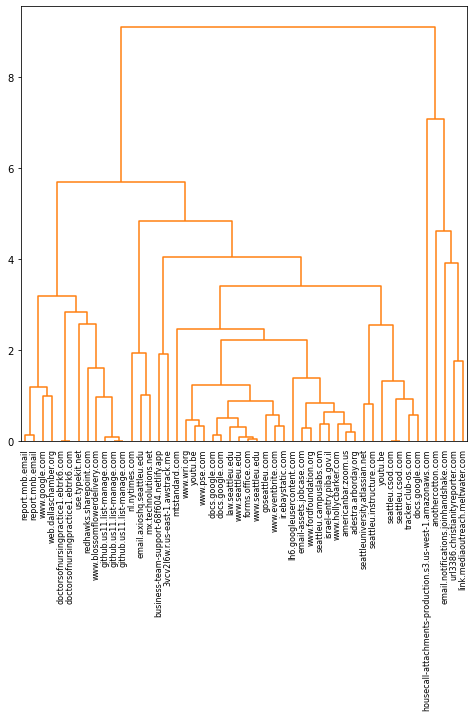

In [431]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=15,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.2 Average linkage clustering

In [432]:
hc_avg = HClust(distance_threshold=0,
                n_clusters=None,
                linkage='average');
hc_avg.fit(X_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

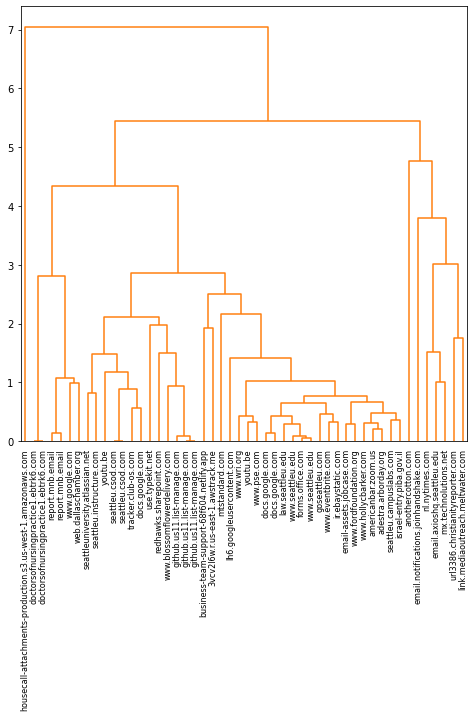

In [433]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_avg)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=16,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.3 Single linkage clustering

In [434]:
hc_sing = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='single');
hc_sing.fit(X_scaled);


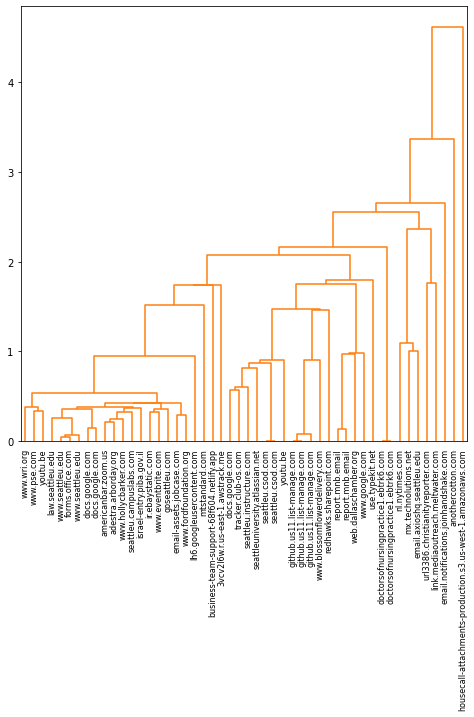

In [435]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_sing)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=5,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.4 Ward linkage clustering

In [436]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

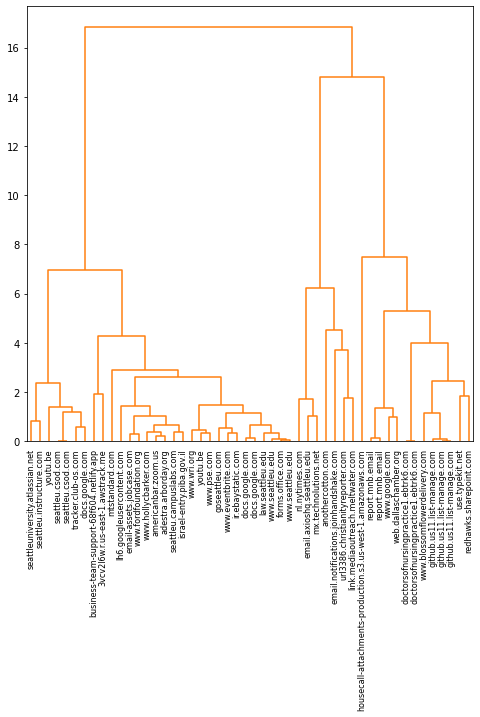

In [437]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=20,
           above_threshold_color='black',labels=X.index.tolist());


In [438]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

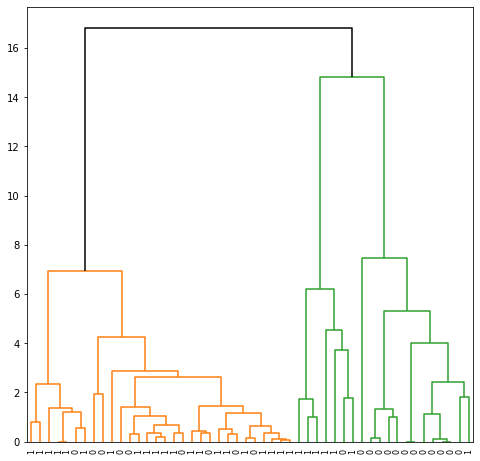

In [439]:
cargs = {'color_threshold':15,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=15,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [440]:
clusters_hc = cut_tree(linkage_comp, n_clusters=2).flatten()

In [441]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)


In [442]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
www.eventbrite.com,61,38,12,18,0,0,0,5
www.seattleu.edu,29,22,0,16,0,0,0,1
forms.office.com,37,29,1,16,0,0,0,1
mtstandard.com,182,137,18,14,0,0,0,18
youtu.be,48,37,3,8,1,1,0,2


In [443]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
report.mnb.email,157,91,41,16,6,1,5,8
www.blossomflowerdelivery.com,136,112,4,29,3,1,2,7
doctorsofnursingpractice1.ebtrk6.com,157,58,82,36,5,1,4,2
github.us11.list-manage.com,102,60,27,27,3,1,2,3
email.axioshq.seattleu.edu,431,339,67,26,0,0,0,19


### 5.2 Hierarchical  clustering 3 Clusters

In [444]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

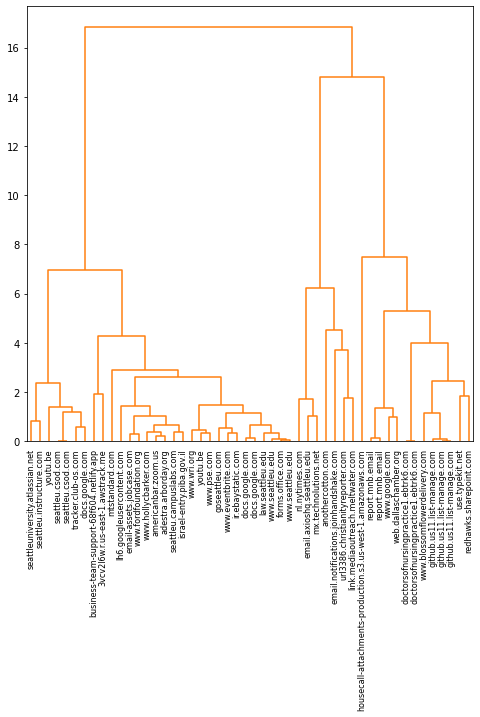

In [445]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=17,
           above_threshold_color='black',labels=X.index.tolist());


In [446]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

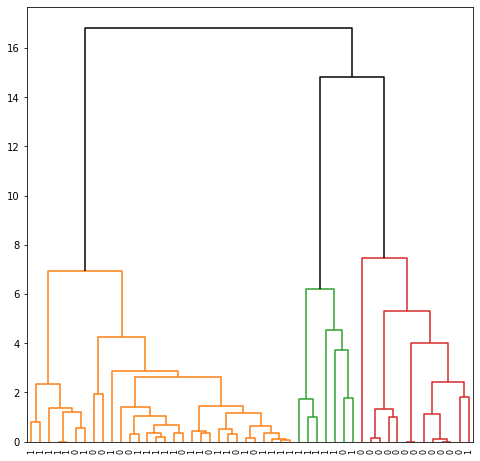

In [447]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=8,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [448]:
clusters_hc = cut_tree(linkage_comp, n_clusters=3).flatten()
clusters_hc

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2,
       0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 2, 1, 0, 1, 1, 2,
       0, 0, 1, 0, 0, 0])

In [449]:
np.where(clusters_hc == 1)[0]

array([ 1,  3,  6,  9, 20, 26, 30, 32, 36, 39, 41, 42, 46], dtype=int64)

In [450]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]
two_indexes = np.where(clusters_hc == 2)[0]
group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)

In [451]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
goseattleu.com,89,67,6,14,0,0,0,7
seattleu.csod.com,71,53,5,17,2,1,1,2
email-assets.jobcase.com,77,64,1,24,0,0,0,5
lh6.googleusercontent.com,170,140,22,25,0,0,0,3
youtu.be,28,21,2,8,0,0,0,1


In [452]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
github.us11.list-manage.com,102,57,30,27,3,1,2,3
github.us11.list-manage.com,102,60,27,27,3,1,2,3
www.google.com,190,153,13,14,6,1,5,3
doctorsofnursingpractice1.ebtrk6.com,157,58,82,36,5,1,4,2
web.dallaschamber.org,210,160,19,21,6,1,5,8


In [453]:
X.iloc[group2_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
email.notifications.joinhandshake.com,715,584,88,37,0,0,0,37
url3386.christianityreporter.com,493,383,88,32,1,1,0,14
nl.nytimes.com,427,352,59,14,0,0,0,7
email.axioshq.seattleu.edu,431,339,67,26,0,0,0,19
link.mediaoutreach.meltwater.com,639,512,94,32,1,1,0,25


### 5.3 Hierarchical  clustering 5 Clusters

In [454]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

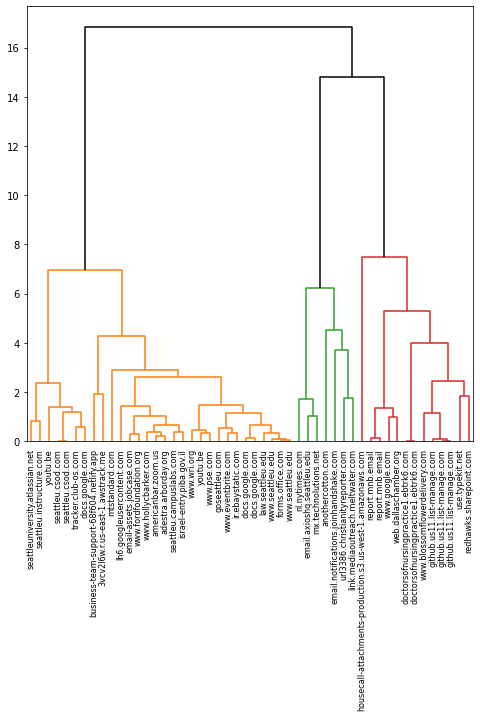

In [455]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=14,
           above_threshold_color='black',labels=X.index.tolist());


In [456]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

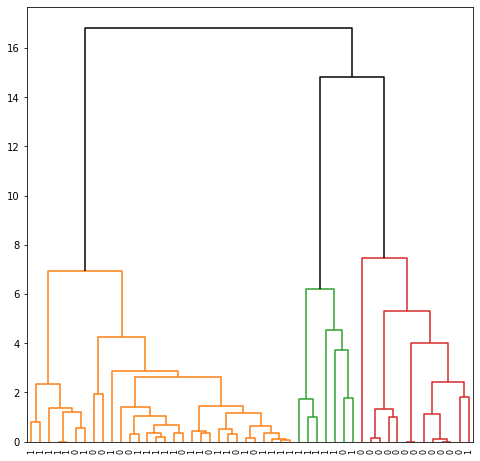

In [457]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=14,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [458]:
clusters_hc = cut_tree(linkage_comp, n_clusters=5).flatten()

In [459]:
clusters_hc

array([0, 1, 0, 1, 0, 2, 1, 0, 0, 3, 2, 4, 0, 0, 0, 0, 0, 0, 4, 0, 1, 4,
       2, 2, 0, 4, 1, 0, 0, 2, 1, 0, 1, 4, 0, 2, 1, 0, 4, 1, 0, 1, 1, 4,
       0, 2, 1, 0, 0, 0])

In [460]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]
two_indexes = np.where(clusters_hc == 2)[0]
three_indexes = np.where(clusters_hc == 3)[0]
four_indexes = np.where(clusters_hc == 4)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
group3_random_indexes = np.random.choice(three_indexes, size=1, replace=False)
group4_random_indexes = np.random.choice(four_indexes, size=5, replace=False)


In [461]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
docs.google.com,84,70,5,15,0,0,0,1
youtu.be,28,21,2,8,0,0,0,1
business-team-support-68f604.netlify.app,56,41,5,40,0,0,0,5
seattleu.campuslabs.com,53,37,8,23,0,0,0,1
docs.google.com,87,69,8,15,0,0,0,2


In [462]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
use.typekit.net,146,56,74,15,3,1,2,1
doctorsofnursingpractice1.ebtrk6.com,157,58,82,36,5,1,4,2
redhawks.sharepoint.com,196,124,46,23,4,1,3,10
report.mnb.email,157,91,41,16,6,1,5,8
report.mnb.email,160,91,43,16,6,1,5,9


In [463]:
X.iloc[group2_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
tracker.club-os.com,96,66,20,19,1,1,0,2
seattleuniversity.atlassian.net,104,69,21,31,1,1,0,2
seattleu.csod.com,71,53,5,17,2,1,1,2
youtu.be,48,37,3,8,1,1,0,2
docs.google.com,111,90,8,15,1,1,0,2


In [464]:
X.iloc[group3_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
housecall-attachments-production.s3.us-west-1.amazonaws.com,394,238,103,59,6,1,5,30


In [465]:
X.iloc[group4_random_indexes]

,URLLength,NoOfLettersInURL,NoOfDegitsInURL,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL
Domain,,,,,,,,
mx.technolutions.net,438,337,77,20,0,0,0,13
link.mediaoutreach.meltwater.com,639,512,94,32,1,1,0,25
nl.nytimes.com,427,352,59,14,0,0,0,7
email.notifications.joinhandshake.com,715,584,88,37,0,0,0,37
email.axioshq.seattleu.edu,431,339,67,26,0,0,0,19


### 5.4 Hierarchical  clustering 2 Clusters, computation of confusion matrix

In [466]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

In [467]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)

In [370]:
clusters_hc = cut_tree(linkage_comp, n_clusters=2).flatten()
clusters_hc

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0])

In [371]:
url_sample_data['label'].unique()

array([1, 0], dtype=int64)

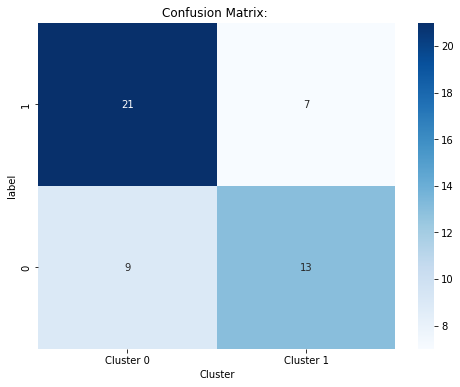

In [376]:
# Switch the 0 and 1 label to match the cluster label
url_sample_data['label'] = 1 - url_sample_data['label']

# Create a confusion matrix
conf_matrix = confusion_matrix(url_sample_data['label'], clusters_hc)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['1','0'])
plt.xlabel('Cluster')
plt.ylabel('label')
plt.title('Confusion Matrix: ')
plt.show()

In [377]:
accuracy = (21+13)/(21+7+9+13)
print("Hierarchical Dendrogram Accuracy: {:.2f}%".format(accuracy*100))

Hierarchical Dendrogram Accuracy: 68.00%


### 6.1 Accuracy Chart

In [468]:
# Import Altair library
import altair as alt

# Phishing label accuracy chart
phishing_clusters = {'Method Name': ['K-Means 2 Clusters', 'K-Means 2 Clusters - SVD 4 PCs', 'Hierarchical 2 Clusters - Ward'],
                'Accuracy': [70.79, 70.00, 68.00]}

accuracy_chart_df = pd.DataFrame(phishing_clusters)

In [469]:
alt.Chart(accuracy_chart_df, title='Cluster Accuracy for Phishing Sites').mark_bar().encode(
    alt.X('Accuracy:Q', title = 'Accuracy (%)', scale=alt.Scale(domain=[0,100])),
    alt.Y('Method Name:N', sort='x'),
).properties(
    width=400,
    height=150
)

alt.Chart(...)